In [1]:
#these column names don't mean very much to us right now 
##we will a look at variables by mapping encoded column names to label

import pandas as pd

p_file = "../1_Raw_Data/data_persons_ca_1yr/psam_p06_master.csv"
all_headers_persons = pd.read_csv(p_file, nrows=0).columns.tolist()

print("Number of columns:", len(all_headers_persons))
print("First 20 columns:", all_headers_persons[:20])
print("Last 10 columns:", all_headers_persons[-10:])

Number of columns: 278
First 20 columns: ['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM']
Last 10 columns: ['PWGTP72', 'PWGTP73', 'PWGTP74', 'PWGTP75', 'PWGTP76', 'PWGTP77', 'PWGTP78', 'PWGTP79', 'PWGTP80', 'year']


In [2]:
import pandas as pd
import requests
import json

# 1) get column names
p_file = "../1_Raw_Data/data_persons_ca_1yr/psam_p06_master.csv"
cols = pd.read_csv(p_file, nrows=0).columns.tolist()

print("Columns in file:", len(cols))
print("Example columns:", cols[:12])

# 2) fetch Census metadata dictionary
url = "https://api.census.gov/data/2023/acs/acs5/pums/variables.json"
meta = requests.get(url)
meta.raise_for_status()
vardict = meta.json()["variables"]

# 3) map each column -> explanation
rows = []
for c in cols:
    info = vardict.get(c, {})
    values_obj = info.get("values")
    rows.append({
        "column": c,
        "label": info.get("label"),
        "predicateType": info.get("predicateType"),
        "values_json": json.dumps(values_obj) if values_obj is not None else None
    })

df_dict = pd.DataFrame(rows)

# 5) save
df_dict.to_csv("EDA_data/all_pums_person_ca_data_dictionary.csv", index=False)
df_dict.head(20)

#see the full result of columns mapped to label (column explanation) in EDA_data/all_pums_person_us_data_dictionary.csv

Columns in file: 278
Example columns: ['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW']


,column,label,predicateType,values_json
0,RT,Record Type,string,"{""item"": {""H"": ""Housing Record or Group Quarte..."
1,SERIALNO,Housing unit/GQ person serial number,string,None
2,DIVISION,Division code,None,"{""item"": {""7"": ""West South Central (South Regi..."
3,SPORDER,Person number,int,"{""range"": [{""min"": ""1"", ""max"": ""20"", ""descript..."
4,PUMA,Public use microdata area code (PUMA) based on...,string,"{""item"": {""00605"": ""Public use microdata area ..."
5,REGION,Region code,None,"{""item"": {""1"": ""Northeast"", ""9"": ""Puerto Rico""..."
6,ADJINC,Adjustment factor for income and earnings doll...,int,"{""item"": {""1019518"": ""2023 factor (1.019518 * ..."
7,PWGTP,Person weight,int,"{""range"": [{""min"": ""1"", ""max"": ""9999"", ""descri..."
8,AGEP,Age,int,"{""item"": {""0"": ""Under 1 year""}, ""range"": [{""mi..."
9,CIT,Citizenship status,int,"{""item"": {""2"": ""Born in Puerto Rico, Guam, the..."


In [3]:
# as you can see from EDA_data/all_pums_person_us_data_dictionary.csv, not all of these columns are useful
## for example, columns that start with F are all allocation flags i.e. missing information inferred using stat methods
### all columns that start with PWG are person weights are used to produce population estimates from sample data
### we don't need these 

## dropping useless columns

def is_useless(col):
    if col.startswith("PWG"):      # person weights + replicates
        return True
    if col.startswith("F"):        # allocation flags
        return True
    if col in ["RT", "SERIALNO", "SPORDER"]:  # pure identifiers
        return True
    return False

df_clean = df_dict.loc[~df_dict["column"].apply(is_useless)].copy()

print("Clean dictionary shape:", df_clean.shape)
df_clean.head()

df_clean.to_csv(
    "EDA_data/suggested_clean_data_dictionary.csv",
    index=False
)

print("Saved: suggested_clean_data_dictionary.csv")

Clean dictionary shape: (118, 4)
Saved: suggested_clean_data_dictionary.csv


In [4]:
## 118 variables is still too many, lets try to cut it down further
# lets try to remove: columns with too many null values, columns of variables that measure the same concept at different resolutions etc. 
import pandas as pd

df = pd.read_csv(
    "EDA_data/suggested_clean_data_dictionary.csv"
)

print("Starting columns:", df.shape[0])

Starting columns: 118


In [5]:
import pandas as pd

dict_path = "EDA_data/suggested_clean_data_dictionary.csv"
df_dict = pd.read_csv(dict_path)

candidate_cols = df_dict["column"].tolist()
print("Number of candidate columns:", len(candidate_cols))

Number of candidate columns: 118


In [6]:
p_file = "../1_Raw_Data/data_persons_ca_1yr/psam_p06_master.csv"

df = pd.read_csv(
    p_file,
    usecols=candidate_cols
)

print("Shape of loaded data:", df.shape)

null_summary = (
    df.isna()
      .sum()
      .reset_index()
      .rename(columns={"index": "column", 0: "n_null"})
)

null_summary["pct_null"] = null_summary["n_null"] / len(df)

null_summary = null_summary.sort_values("pct_null", ascending=False)

# load dictionary if not already loaded
df_dict = pd.read_csv(
    "EDA_data/suggested_clean_data_dictionary.csv"
)

# keep only what we need
labels = df_dict[["column", "label"]]

# merge labels into null summary
null_summary = null_summary.merge(
    labels,
    on="column",
    how="left"
)

# reorder columns for readability
null_summary = null_summary[
    ["column", "label", "n_null", "pct_null"]
]


Shape of loaded data: (1928458, 118)


In [7]:
null_summary.head(60)

,column,label,n_null,pct_null
0,GCM,Length of time responsible for grandchildren,1917736,0.994440
1,DRAT,Veteran service connected disability rating (p...,1907260,0.989008
2,GCR,Grandparents responsible for grandchildren,1876176,0.972889
3,SFR,Subfamily relationship,1841007,0.954652
4,SFN,Subfamily number,1841007,0.954652
5,VPS,Veteran period of service,1839864,0.954060
6,MLPJ,Served World War II (December 1941 - December ...,1839864,0.954060
7,MLPE,Served Vietnam era (August 1964 - April 1975),1839864,0.954060
8,MLPCD,Served May 1975 - July 1990,1839864,0.954060
9,MLPH,Served Korean War (July 1950 - January 1955),1839864,0.954060


In [8]:
# lets drop any columns that have over 60% null values 

HIGH_NULL_CUTOFF = 0.60

# 1) Load your current clean dictionary (the 123-col list)
df_dict = pd.read_csv(dict_path)
candidate_cols = df_dict["column"].tolist()

# 2) Load ONLY those columns from the person CSV
df = pd.read_csv(p_file, usecols=candidate_cols)

# 3) Compute null rates
null_summary = (
    df.isna()
      .sum()
      .reset_index()
      .rename(columns={"index": "column", 0: "n_null"})
)
null_summary["pct_null"] = null_summary["n_null"] / len(df)

# 4) Identify high-null columns to drop
high_null_cols = null_summary.loc[
    null_summary["pct_null"] >= HIGH_NULL_CUTOFF,
    "column"
].tolist()

print(f"Columns in dict before: {len(candidate_cols)}")
print(f"Dropping (pct_null >= {HIGH_NULL_CUTOFF}): {len(high_null_cols)}")
print("Dropped columns:", high_null_cols)

# 5) Prune dictionary and overwrite the same file
df_dict_pruned = df_dict.loc[~df_dict["column"].isin(high_null_cols)].copy()
df_dict_pruned.to_csv(dict_path, index=False)

print(f"Columns in dict after: {df_dict_pruned.shape[0]}")

Columns in dict before: 118
Dropping (pct_null >= 0.6): 31
Dropped columns: ['CITWP', 'DRAT', 'DRATX', 'ENG', 'GCM', 'GCR', 'JWMNP', 'JWRIP', 'MLPA', 'MLPB', 'MLPCD', 'MLPE', 'MLPFG', 'MLPH', 'MLPJ', 'SCHG', 'YOEP', 'DECADE', 'DRIVESP', 'ESP', 'JWAP', 'JWDP', 'LANP', 'MIGPUMA', 'MIGSP', 'NOP', 'SCIENGP', 'SCIENGRLP', 'SFN', 'SFR', 'VPS']
Columns in dict after: 87


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure POVPIP is numeric and drop missing values for exploration
povpip = pd.to_numeric(df["POVPIP"], errors="coerce").dropna()

# Basic summary statistics
povpip.describe()


count    1.857626e+06
mean     3.393265e+02
std      1.664055e+02
min      0.000000e+00
25%      1.940000e+02
50%      3.810000e+02
75%      5.010000e+02
max      5.010000e+02
Name: POVPIP, dtype: float64

## Target Variable Analysis (POVPIP)

POVPIP is the income-to-poverty ratio recode:
- Values 0-100: Below poverty threshold (100 = exactly at poverty line)
- Values 101-500: Above poverty threshold (up to 5x poverty line)
- Value 501: 501% or more of poverty threshold (capped)

For our classification task, POVPIP < 100 indicates being in poverty.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Load data
p_file = "../1_Raw_Data/data_persons_ca_1yr/psam_p06_master.csv"
dict_path = "EDA_data/suggested_clean_data_dictionary.csv"

df_dict = pd.read_csv(dict_path)
candidate_cols = df_dict["column"].tolist()

print(f"Loading {len(candidate_cols)} columns...")
df = pd.read_csv(p_file, usecols=candidate_cols)
print(f"Data shape: {df.shape}")
print(f"Total records: {len(df):,}")

Loading 87 columns...
Data shape: (1928458, 87)
Total records: 1,928,458


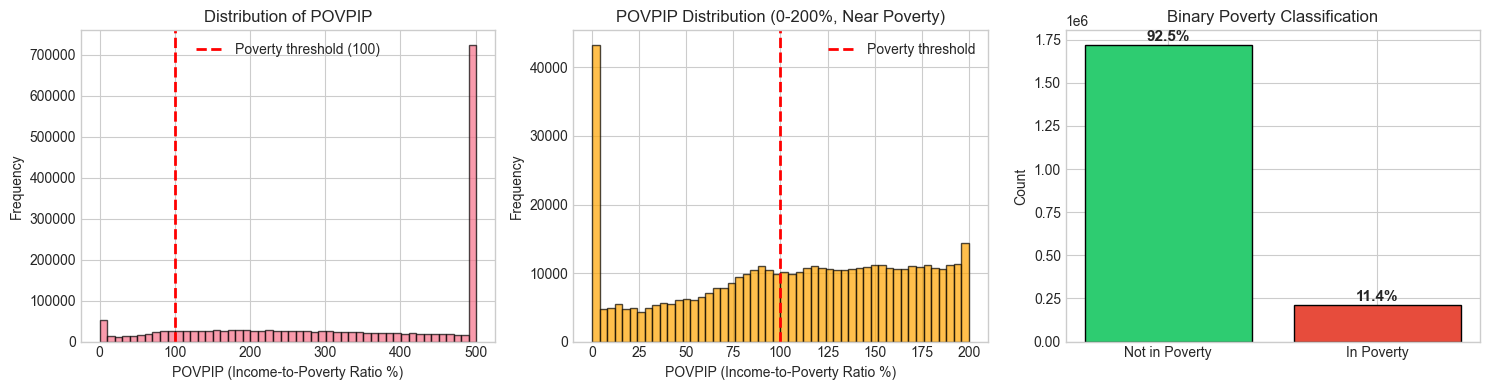


Poverty Statistics:
Records with POVPIP data: 1,857,626
Records missing POVPIP: 70,832

Poverty breakdown (POVPIP < 100):
  In poverty: 210,964 (11.36%)
  Not in poverty: 1,717,494 (92.46%)


In [11]:
# POVPIP Distribution Analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Raw POVPIP histogram
povpip = df["POVPIP"].dropna()
axes[0].hist(povpip, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=100, color='red', linestyle='--', linewidth=2, label='Poverty threshold (100)')
axes[0].set_xlabel('POVPIP (Income-to-Poverty Ratio %)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of POVPIP')
axes[0].legend()

# 2. Zoomed in view (0-200)
axes[1].hist(povpip[povpip <= 200], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=100, color='red', linestyle='--', linewidth=2, label='Poverty threshold')
axes[1].set_xlabel('POVPIP (Income-to-Poverty Ratio %)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('POVPIP Distribution (0-200%, Near Poverty)')
axes[1].legend()

# 3. Binary poverty classification
df['poverty'] = (df['POVPIP'] < 100).astype(int)
poverty_counts = df['poverty'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = axes[2].bar(['Not in Poverty', 'In Poverty'], [poverty_counts.get(0, 0), poverty_counts.get(1, 0)], 
                   color=colors, edgecolor='black')
axes[2].set_ylabel('Count')
axes[2].set_title('Binary Poverty Classification')

# Add percentage labels on bars
for bar, count in zip(bars, [poverty_counts.get(0, 0), poverty_counts.get(1, 0)]):
    pct = count / len(df[df['POVPIP'].notna()]) * 100
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_data/povpip_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPoverty Statistics:")
print(f"Records with POVPIP data: {povpip.shape[0]:,}")
print(f"Records missing POVPIP: {df['POVPIP'].isna().sum():,}")
print(f"\nPoverty breakdown (POVPIP < 100):")
print(f"  In poverty: {poverty_counts.get(1, 0):,} ({poverty_counts.get(1, 0)/len(df[df['POVPIP'].notna()])*100:.2f}%)")
print(f"  Not in poverty: {poverty_counts.get(0, 0):,} ({poverty_counts.get(0, 0)/len(df[df['POVPIP'].notna()])*100:.2f}%)")

## Correlation Analysis with POVPIP

We'll compute correlations between numeric features and the target variable (POVPIP) to identify which features are most predictive of poverty status.

In [12]:
# Identify numeric columns for correlation analysis
import warnings

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove POVPIP and poverty (our target) from feature list
feature_cols = [c for c in numeric_cols if c not in ['POVPIP', 'poverty']]

print(f"Total numeric features for correlation: {len(feature_cols)}")

# Calculate correlation with POVPIP (using only non-null POVPIP records)
df_valid = df[df['POVPIP'].notna()].copy()

correlations = {}
for col in feature_cols:
    col_data = df_valid[col].dropna()
    
    # Skip if not enough data or constant values
    if len(col_data) < 100:
        continue
    if col_data.nunique() <= 1:
        continue
    
    # Get matching POVPIP values
    valid_idx = col_data.index
    povpip_matched = df_valid.loc[valid_idx, 'POVPIP']
    
    # Standardize to avoid overflow with large values
    col_standardized = (col_data - col_data.mean()) / (col_data.std() + 1e-10)
    povpip_standardized = (povpip_matched - povpip_matched.mean()) / (povpip_matched.std() + 1e-10)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            corr, p_val = stats.pearsonr(col_standardized, povpip_standardized)
            if not np.isnan(corr) and not np.isinf(corr):
                correlations[col] = {'correlation': corr, 'p_value': p_val, 'abs_corr': abs(corr)}
        except Exception:
            pass  # Skip problematic columns

# Convert to DataFrame and sort by absolute correlation
corr_df = pd.DataFrame(correlations).T
corr_df = corr_df.sort_values('abs_corr', ascending=False)
corr_df = corr_df.reset_index().rename(columns={'index': 'column'})

# Merge with labels for interpretability
corr_df = corr_df.merge(df_dict[['column', 'label']], on='column', how='left')

# Create a short label for display
corr_df['short_label'] = corr_df['label'].apply(lambda x: str(x)[:45] + '...' if len(str(x)) > 45 else str(x))
corr_df['display_name'] = corr_df['column'] + ' - ' + corr_df['short_label']

print(f"\nTop 35 features correlated with POVPIP (income-to-poverty ratio):")
print("-" * 90)
for i, row in corr_df.head(35).iterrows():
    print(f"{row['column']:12} | r={row['correlation']:+.3f} | {row['short_label']}")

Total numeric features for correlation: 84

Top 35 features correlated with POVPIP (income-to-poverty ratio):
------------------------------------------------------------------------------------------
PRIVCOV      | r=-0.470 | Private health insurance coverage recode
HINS4        | r=+0.454 | Medicaid, Medical Assistance, or any kind of ...
HINS1        | r=-0.439 | Insurance through a current or former employe...
PINCP        | r=+0.416 | Total person's income (use ADJINC to adjust t...
PERNP        | r=+0.372 | Total person's earnings (use ADJINC to adjust...
WAGP         | r=+0.363 | Wages or salary income past 12 months (use AD...
PUBCOV       | r=+0.350 | Public health coverage recode
OCCP         | r=-0.284 | Occupation recode for 2018 and later based on...
WRK          | r=-0.265 | Worked last week
SCHL         | r=+0.264 | Educational attainment
ESR          | r=-0.250 | Employment status recode
WKL          | r=-0.245 | When last worked
MSP          | r=-0.244 | Married, spous

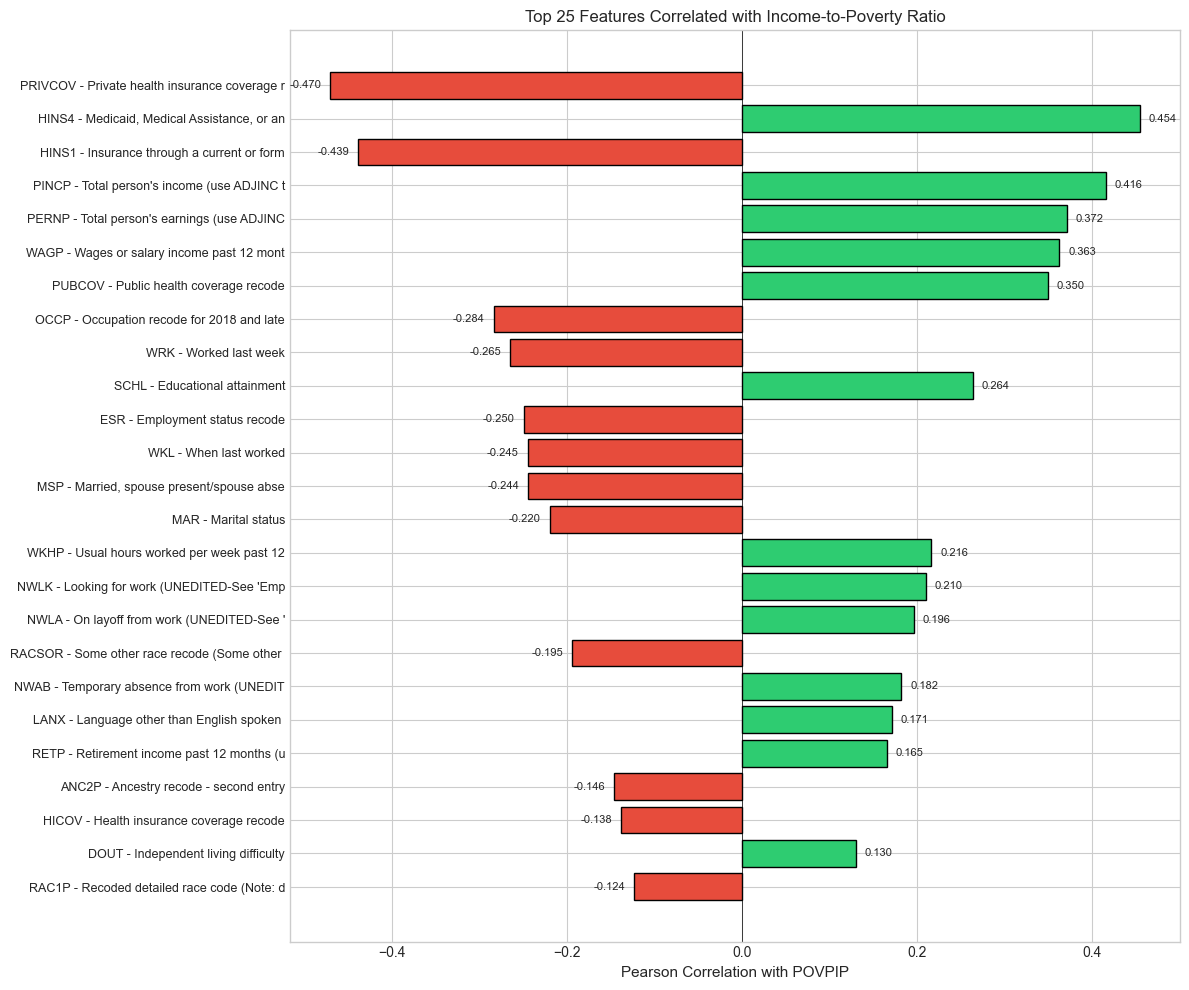


Interpretation:
- GREEN (positive): Higher values = HIGHER income-to-poverty ratio (less likely to be poor)
- RED (negative): Higher values = LOWER income-to-poverty ratio (more likely to be poor)


In [13]:
# Visualize top correlations with POVPIP (with labels!)
top_n = 25
top_corr = corr_df.head(top_n).copy()

fig, ax = plt.subplots(figsize=(12, 10))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_corr['correlation']]

# Use display names (code + short label)
y_labels = [f"{row['column']} - {row['short_label'][:35]}" for _, row in top_corr.iterrows()]

ax.barh(range(len(top_corr)), top_corr['correlation'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(y_labels, fontsize=9)
ax.set_xlabel('Pearson Correlation with POVPIP', fontsize=11)
ax.set_title(f'Top {top_n} Features Correlated with Income-to-Poverty Ratio', fontsize=12)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.invert_yaxis()

# Add correlation values on bars
for i, (idx, row) in enumerate(top_corr.iterrows()):
    ax.text(row['correlation'] + 0.01 if row['correlation'] > 0 else row['correlation'] - 0.01, 
            i, f"{row['correlation']:.3f}", va='center', 
            ha='left' if row['correlation'] > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.savefig('EDA_data/correlation_with_povpip.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- GREEN (positive): Higher values = HIGHER income-to-poverty ratio (less likely to be poor)")
print("- RED (negative): Higher values = LOWER income-to-poverty ratio (more likely to be poor)")

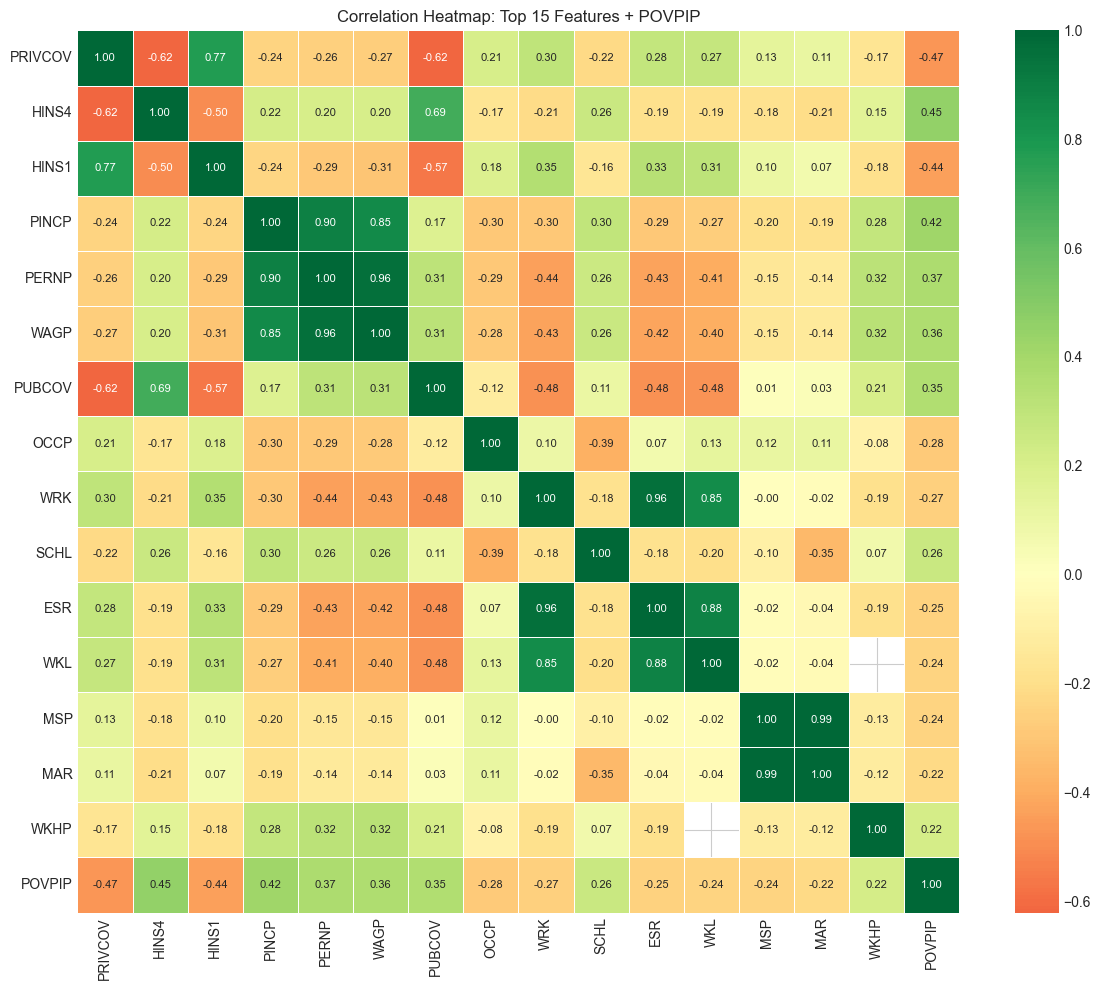

In [14]:
# Correlation heatmap for top features + POVPIP
top_features = corr_df.head(15)['column'].tolist() + ['POVPIP']

# Create correlation matrix for these features
corr_matrix = df_valid[top_features].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, 
            fmt='.2f', linewidths=0.5, ax=ax,
            annot_kws={'size': 8})
ax.set_title('Correlation Heatmap: Top 15 Features + POVPIP')
plt.tight_layout()
plt.savefig('EDA_data/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## Variance Analysis

Features with very low variance don't provide much discriminative power. We'll identify features with:
- Near-zero variance (most values are the same)
- Highly skewed distributions

These features are candidates for removal to reduce dimensionality.

=== Low Variance Features (mode > 95% of values) ===
Found 19 features with extremely low variance:
      column    mode_pct  unique_values
0   DIVISION  100.000000              1
2     REGION  100.000000              1
76     RACNH   99.770075              2
20     HINS7   99.582931              2
78     RACPI   99.439241              2
24     MARHD   99.122706              2
27     MARHW   99.105267              2
19     HINS6   98.248134              2
25     MARHM   97.690375              2
18     HINS5   97.671559              2
9       DEYE   97.637180              2
73   RACAIAN   96.893114              2
8       DEAR   96.405677              2
7       DDRS   96.386947              2
13       GCL   95.834260              2
35      NWRE   95.400196              3
66     POWSP   99.568432             58
37       PAP   98.157733            313
43      SSIP   96.597136            237


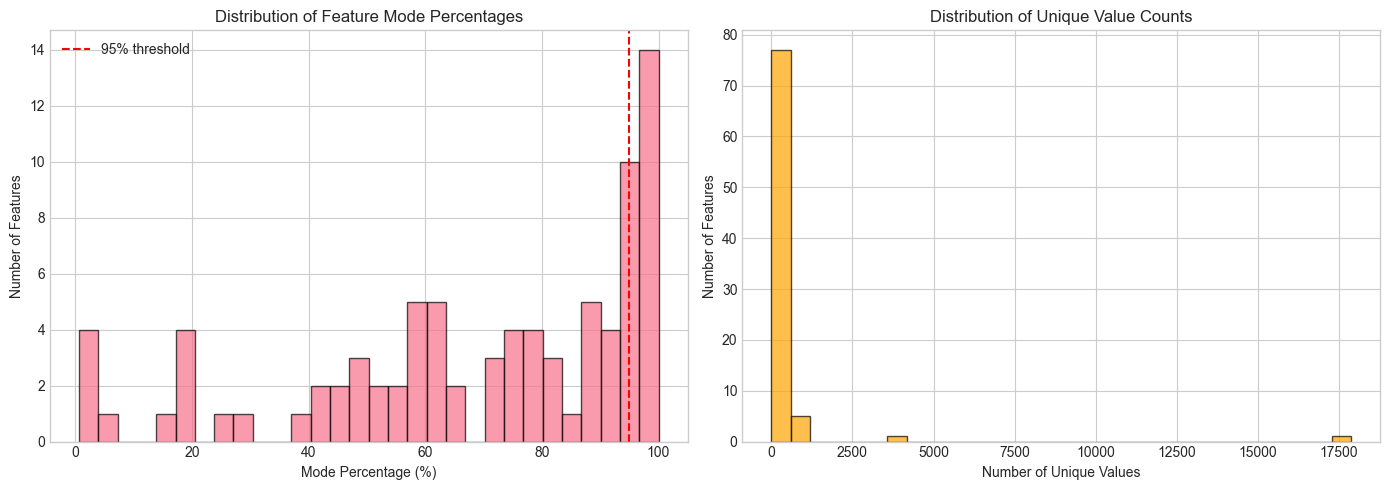

In [15]:
# Variance analysis for numeric features
variance_stats = []

for col in feature_cols:
    if col in df.columns:
        col_data = df[col].dropna()
        if len(col_data) > 0:
            variance_stats.append({
                'column': col,
                'variance': col_data.var(),
                'std': col_data.std(),
                'unique_values': col_data.nunique(),
                'mode_pct': col_data.value_counts(normalize=True).iloc[0] * 100 if len(col_data) > 0 else 0,
                'non_null_count': len(col_data)
            })

variance_df = pd.DataFrame(variance_stats)
variance_df = variance_df.sort_values('variance', ascending=True)

# Low variance features (mode > 95%)
low_var_features = variance_df[variance_df['mode_pct'] > 95]
print(f"=== Low Variance Features (mode > 95% of values) ===")
print(f"Found {len(low_var_features)} features with extremely low variance:")
print(low_var_features[['column', 'mode_pct', 'unique_values']].to_string())

# Visualize variance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of mode percentages
axes[0].hist(variance_df['mode_pct'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=95, color='red', linestyle='--', label='95% threshold')
axes[0].set_xlabel('Mode Percentage (%)')
axes[0].set_ylabel('Number of Features')
axes[0].set_title('Distribution of Feature Mode Percentages')
axes[0].legend()

# Number of unique values per feature
axes[1].hist(variance_df['unique_values'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Number of Unique Values')
axes[1].set_ylabel('Number of Features')
axes[1].set_title('Distribution of Unique Value Counts')

plt.tight_layout()
plt.savefig('EDA_data/variance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## Poverty Analysis by Key Demographics

Exploring how poverty rates vary across key demographic and socioeconomic factors.

/var/folders/7w/j0bpp7hx3pbcmhhkspmsyjx40000gp/T/ipykernel_26296/1496007082.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  poverty_by_age = df_analysis.groupby('age_group')['poverty'].agg(['mean', 'count']).reset_index()


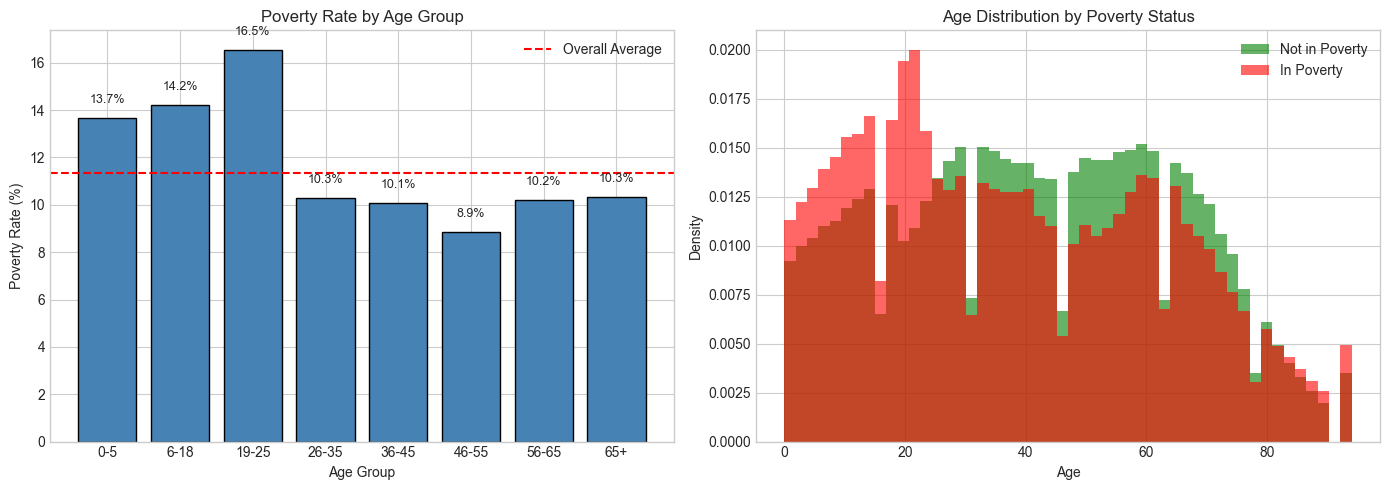

Age Group  Poverty Rate  Count
      0-5     13.676714  90007
     6-18     14.209675 281808
    19-25     16.540929 148722
    26-35     10.287880 252987
    36-45     10.067754 240133
    46-55      8.851439 241328
    56-65     10.191664 254247
      65+     10.339941 332352


In [16]:
# Poverty by Age Groups
df_analysis = df[df['POVPIP'].notna()].copy()

# Create age groups
df_analysis['age_group'] = pd.cut(df_analysis['AGEP'], 
                                   bins=[0, 5, 18, 25, 35, 45, 55, 65, 100],
                                   labels=['0-5', '6-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+'])

poverty_by_age = df_analysis.groupby('age_group')['poverty'].agg(['mean', 'count']).reset_index()
poverty_by_age.columns = ['Age Group', 'Poverty Rate', 'Count']
poverty_by_age['Poverty Rate'] = poverty_by_age['Poverty Rate'] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Poverty rate by age
bars = axes[0].bar(poverty_by_age['Age Group'], poverty_by_age['Poverty Rate'], 
                   color='steelblue', edgecolor='black')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Poverty Rate (%)')
axes[0].set_title('Poverty Rate by Age Group')
axes[0].axhline(y=df_analysis['poverty'].mean()*100, color='red', linestyle='--', label='Overall Average')
axes[0].legend()
for bar, rate in zip(bars, poverty_by_age['Poverty Rate']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

# Age distribution by poverty status
df_analysis[df_analysis['poverty']==0]['AGEP'].hist(ax=axes[1], bins=50, alpha=0.6, 
                                                     label='Not in Poverty', color='green', density=True)
df_analysis[df_analysis['poverty']==1]['AGEP'].hist(ax=axes[1], bins=50, alpha=0.6, 
                                                     label='In Poverty', color='red', density=True)
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Density')
axes[1].set_title('Age Distribution by Poverty Status')
axes[1].legend()

plt.tight_layout()
plt.savefig('EDA_data/poverty_by_age.png', dpi=150, bbox_inches='tight')
plt.show()

print(poverty_by_age.to_string(index=False))

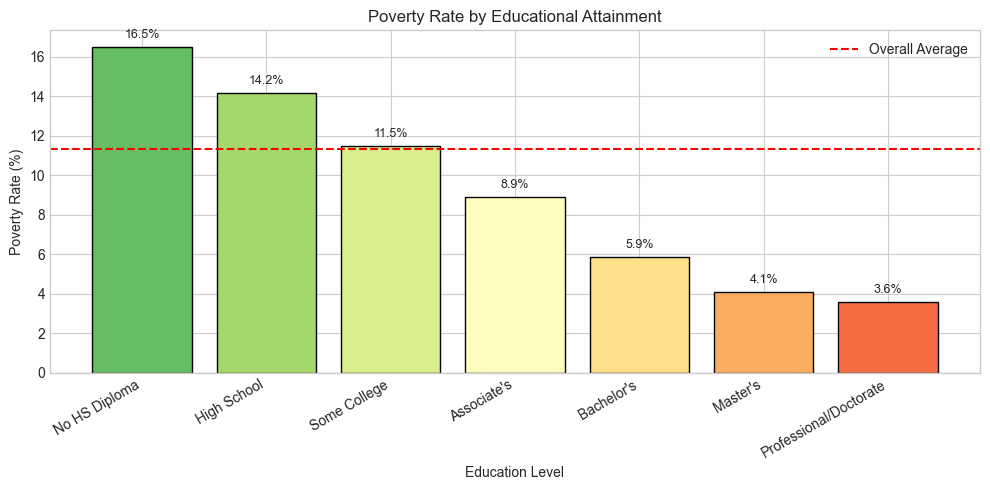


Poverty Rate by Education Level:
             Education  Poverty Rate  Count
         No HS Diploma     16.511896 519801
           High School     14.173638 307698
          Some College     11.467560 317234
           Associate's      8.922288 117369
            Bachelor's      5.853017 333657
              Master's      4.077182 142157
Professional/Doctorate      3.611408  69142


In [17]:
# Poverty by Education Level (SCHL - Educational Attainment)
# SCHL values: 1-15 = no high school diploma, 16-17 = high school, 18-19 = some college, 
# 20 = Associate's, 21 = Bachelor's, 22 = Master's, 23 = Professional, 24 = Doctorate

edu_mapping = {
    'No HS Diploma': list(range(1, 16)),
    'High School': [16, 17],
    'Some College': [18, 19],
    "Associate's": [20],
    "Bachelor's": [21],
    "Master's": [22],
    'Professional/Doctorate': [23, 24]
}

def map_education(schl):
    if pd.isna(schl):
        return None
    for label, values in edu_mapping.items():
        if int(schl) in values:
            return label
    return None

df_analysis['education'] = df_analysis['SCHL'].apply(map_education)

poverty_by_edu = df_analysis.dropna(subset=['education']).groupby('education')['poverty'].agg(['mean', 'count']).reset_index()
poverty_by_edu.columns = ['Education', 'Poverty Rate', 'Count']
poverty_by_edu['Poverty Rate'] = poverty_by_edu['Poverty Rate'] * 100

# Sort by education level order
edu_order = ['No HS Diploma', 'High School', 'Some College', "Associate's", "Bachelor's", "Master's", 'Professional/Doctorate']
poverty_by_edu['Education'] = pd.Categorical(poverty_by_edu['Education'], categories=edu_order, ordered=True)
poverty_by_edu = poverty_by_edu.sort_values('Education')

fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(poverty_by_edu)))
bars = ax.bar(poverty_by_edu['Education'], poverty_by_edu['Poverty Rate'], color=colors, edgecolor='black')
ax.set_xlabel('Education Level')
ax.set_ylabel('Poverty Rate (%)')
ax.set_title('Poverty Rate by Educational Attainment')
ax.axhline(y=df_analysis['poverty'].mean()*100, color='red', linestyle='--', label='Overall Average')
ax.legend()
plt.xticks(rotation=30, ha='right')
for bar, rate in zip(bars, poverty_by_edu['Poverty Rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('EDA_data/poverty_by_education.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Education Level:")
print(poverty_by_edu.to_string(index=False))

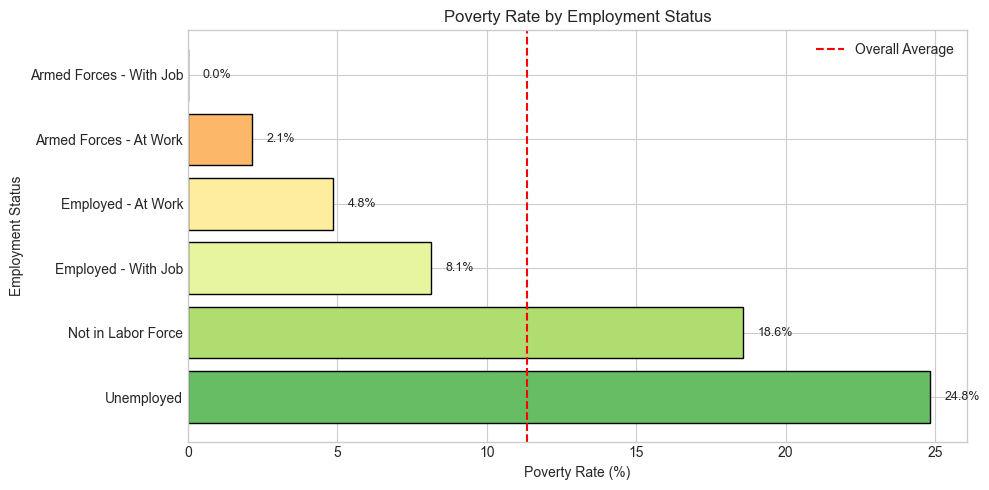


Poverty Rate by Employment Status:
      Employment Status  Poverty Rate  Count
             Unemployed     24.819641  54336
     Not in Labor Force     18.563461 585198
    Employed - With Job      8.118319  23293
     Employed - At Work      4.838878 869995
 Armed Forces - At Work      2.125148   4235
Armed Forces - With Job      0.000000     20


In [18]:
# Poverty by Employment Status (ESR - Employment Status Recode)
esr_mapping = {
    1: 'Employed - At Work',
    2: 'Employed - With Job',
    3: 'Unemployed',
    4: 'Armed Forces - At Work',
    5: 'Armed Forces - With Job',
    6: 'Not in Labor Force'
}

df_analysis['employment'] = df_analysis['ESR'].map(esr_mapping)

poverty_by_emp = df_analysis.dropna(subset=['employment']).groupby('employment')['poverty'].agg(['mean', 'count']).reset_index()
poverty_by_emp.columns = ['Employment Status', 'Poverty Rate', 'Count']
poverty_by_emp['Poverty Rate'] = poverty_by_emp['Poverty Rate'] * 100
poverty_by_emp = poverty_by_emp.sort_values('Poverty Rate', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(poverty_by_emp)))
bars = ax.barh(poverty_by_emp['Employment Status'], poverty_by_emp['Poverty Rate'], color=colors, edgecolor='black')
ax.set_xlabel('Poverty Rate (%)')
ax.set_ylabel('Employment Status')
ax.set_title('Poverty Rate by Employment Status')
ax.axvline(x=df_analysis['poverty'].mean()*100, color='red', linestyle='--', label='Overall Average')
ax.legend()
for bar, rate in zip(bars, poverty_by_emp['Poverty Rate']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{rate:.1f}%', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('EDA_data/poverty_by_employment.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Employment Status:")
print(poverty_by_emp.to_string(index=False))

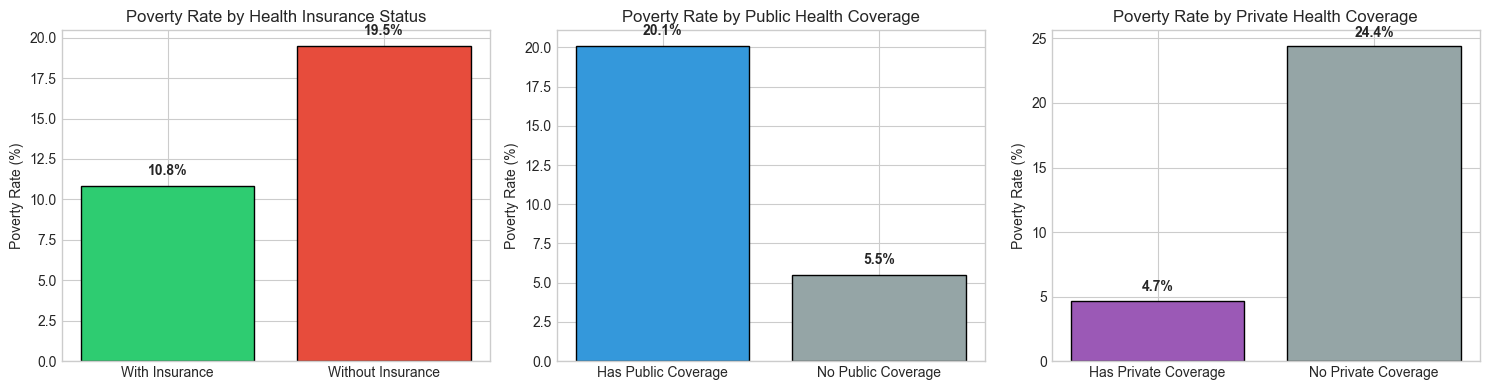

In [19]:
# Poverty by Health Insurance Status
# HICOV: 1 = With health insurance, 2 = Without health insurance
hicov_mapping = {1: 'With Insurance', 2: 'Without Insurance'}
df_analysis['health_insurance'] = df_analysis['HICOV'].map(hicov_mapping)

# Also look at public vs private coverage
df_analysis['public_coverage'] = df_analysis['PUBCOV'].map({1: 'Has Public Coverage', 2: 'No Public Coverage'})
df_analysis['private_coverage'] = df_analysis['PRIVCOV'].map({1: 'Has Private Coverage', 2: 'No Private Coverage'})

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Health insurance coverage
poverty_by_ins = df_analysis.dropna(subset=['health_insurance']).groupby('health_insurance')['poverty'].mean() * 100
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(poverty_by_ins.index, poverty_by_ins.values, color=colors, edgecolor='black')
axes[0].set_ylabel('Poverty Rate (%)')
axes[0].set_title('Poverty Rate by Health Insurance Status')
for bar, rate in zip(bars, poverty_by_ins.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Public coverage
poverty_by_pub = df_analysis.dropna(subset=['public_coverage']).groupby('public_coverage')['poverty'].mean() * 100
colors = ['#3498db', '#95a5a6']
bars = axes[1].bar(poverty_by_pub.index, poverty_by_pub.values, color=colors, edgecolor='black')
axes[1].set_ylabel('Poverty Rate (%)')
axes[1].set_title('Poverty Rate by Public Health Coverage')
for bar, rate in zip(bars, poverty_by_pub.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Private coverage
poverty_by_priv = df_analysis.dropna(subset=['private_coverage']).groupby('private_coverage')['poverty'].mean() * 100
colors = ['#9b59b6', '#95a5a6']
bars = axes[2].bar(poverty_by_priv.index, poverty_by_priv.values, color=colors, edgecolor='black')
axes[2].set_ylabel('Poverty Rate (%)')
axes[2].set_title('Poverty Rate by Private Health Coverage')
for bar, rate in zip(bars, poverty_by_priv.values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_data/poverty_by_health_insurance.png', dpi=150, bbox_inches='tight')
plt.show()

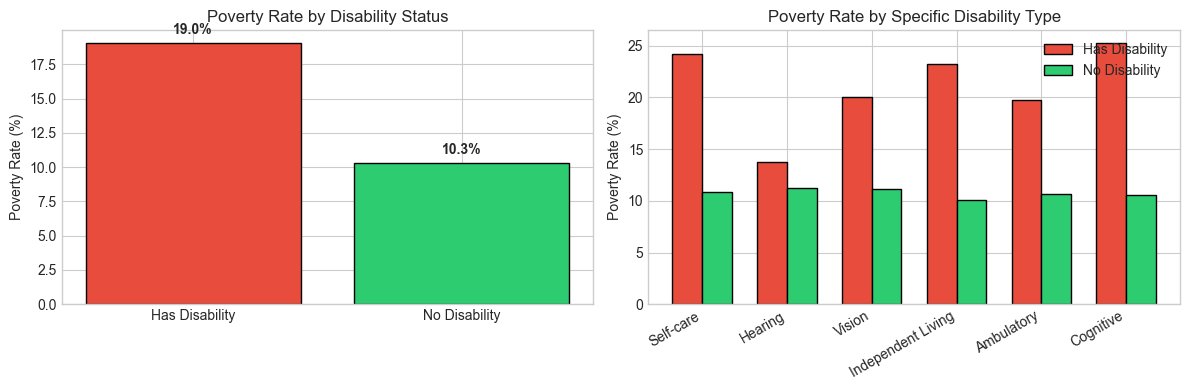


Poverty Rates by Disability Type:
   Disability Type  Has Disability  No Disability
         Self-care       24.192600      10.847603
           Hearing       13.703281      11.271826
            Vision       19.984437      11.161330
Independent Living       23.224930      10.067157
        Ambulatory       19.785148      10.651508
         Cognitive       25.204411      10.517637


In [20]:
# Poverty by Disability Status
dis_mapping = {1: 'Has Disability', 2: 'No Disability'}
df_analysis['disability'] = df_analysis['DIS'].map(dis_mapping)

poverty_by_dis = df_analysis.dropna(subset=['disability']).groupby('disability')['poverty'].agg(['mean', 'count']).reset_index()
poverty_by_dis.columns = ['Disability Status', 'Poverty Rate', 'Count']
poverty_by_dis['Poverty Rate'] = poverty_by_dis['Poverty Rate'] * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Overall disability
colors = ['#e74c3c', '#2ecc71']
bars = axes[0].bar(poverty_by_dis['Disability Status'], poverty_by_dis['Poverty Rate'], color=colors, edgecolor='black')
axes[0].set_ylabel('Poverty Rate (%)')
axes[0].set_title('Poverty Rate by Disability Status')
for bar, rate in zip(bars, poverty_by_dis['Poverty Rate']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Individual disability types
disability_cols = ['DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DREM']
disability_labels = ['Self-care', 'Hearing', 'Vision', 'Independent Living', 'Ambulatory', 'Cognitive']

disability_rates = []
for col, label in zip(disability_cols, disability_labels):
    has_dis = df_analysis[df_analysis[col] == 1]['poverty'].mean() * 100
    no_dis = df_analysis[df_analysis[col] == 2]['poverty'].mean() * 100
    disability_rates.append({'Disability Type': label, 'Has Disability': has_dis, 'No Disability': no_dis})

dis_df = pd.DataFrame(disability_rates)

x = np.arange(len(dis_df))
width = 0.35
bars1 = axes[1].bar(x - width/2, dis_df['Has Disability'], width, label='Has Disability', color='#e74c3c', edgecolor='black')
bars2 = axes[1].bar(x + width/2, dis_df['No Disability'], width, label='No Disability', color='#2ecc71', edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(dis_df['Disability Type'], rotation=30, ha='right')
axes[1].set_ylabel('Poverty Rate (%)')
axes[1].set_title('Poverty Rate by Specific Disability Type')
axes[1].legend()

plt.tight_layout()
plt.savefig('EDA_data/poverty_by_disability.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rates by Disability Type:")
print(dis_df.to_string(index=False))

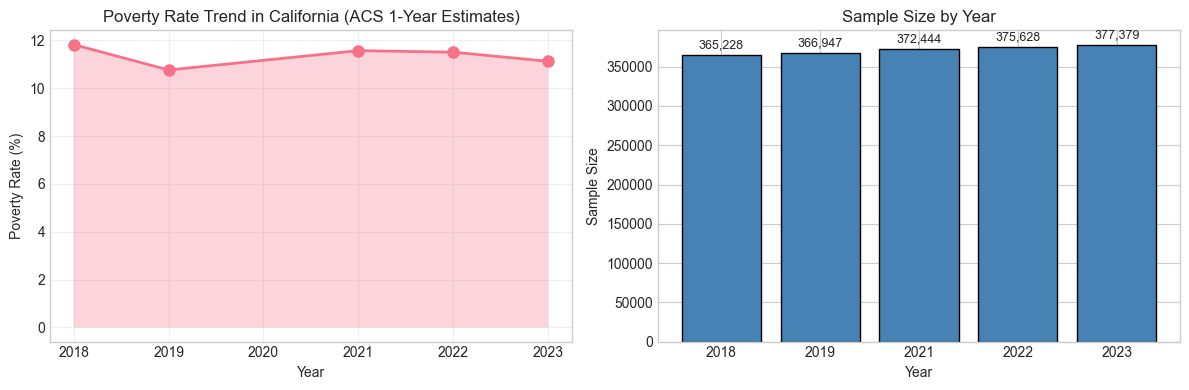


Poverty Rate by Year:
 Year  Poverty Rate  Count
 2018     11.824395 365228
 2019     10.761227 366947
 2021     11.570599 372444
 2022     11.505000 375628
 2023     11.124095 377379


In [21]:
# Poverty Trends Over Time (by Year)
poverty_by_year = df_analysis.groupby('year')['poverty'].agg(['mean', 'count']).reset_index()
poverty_by_year.columns = ['Year', 'Poverty Rate', 'Count']
poverty_by_year['Poverty Rate'] = poverty_by_year['Poverty Rate'] * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Poverty rate by year
axes[0].plot(poverty_by_year['Year'], poverty_by_year['Poverty Rate'], marker='o', linewidth=2, markersize=8)
axes[0].fill_between(poverty_by_year['Year'], poverty_by_year['Poverty Rate'], alpha=0.3)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Poverty Rate (%)')
axes[0].set_title('Poverty Rate Trend in California (ACS 1-Year Estimates)')
axes[0].grid(True, alpha=0.3)

# Sample size by year
axes[1].bar(poverty_by_year['Year'].astype(str), poverty_by_year['Count'], color='steelblue', edgecolor='black')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Sample Size')
axes[1].set_title('Sample Size by Year')
for i, (yr, cnt) in enumerate(zip(poverty_by_year['Year'], poverty_by_year['Count'])):
    axes[1].text(i, cnt + 5000, f'{cnt:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('EDA_data/poverty_by_year.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Year:")
print(poverty_by_year.to_string(index=False))

## Feature Reduction Recommendations

Based on our analysis, we'll identify features to keep and features to drop based on:
1. **Avoid Data Leakage** - Remove PINCP (total income) and PERNP (total earnings) since POVPIP is calculated from income
2. **Keep Income Sources** - Keep specific income types (wages, retirement, etc.) to see which matter
3. **Correlation with POVPIP** - Keep features with |correlation| >= 0.08
4. **Variance** - Drop features with very low variance (mode >95%)
5. **Keep Both Summary & Detail** - Include both recode summaries and detailed variables

In [22]:
# Feature Selection Strategy

# 1. LEAKAGE FEATURES TO EXCLUDE
# PINCP and PERNP are used to calculate POVPIP - including them would be data leakage
leakage_features = ['PINCP', 'PERNP']
print("=== Features to EXCLUDE (Data Leakage) ===")
print("These are directly used to calculate POVPIP (income / poverty threshold):")
for f in leakage_features:
    if f in corr_df['column'].values:
        row = corr_df[corr_df['column'] == f].iloc[0]
        print(f"  {f}: {row['short_label']} (r={row['correlation']:.3f})")

# 2. Identify features with meaningful correlation (|r| >= 0.08)
min_corr = 0.08
high_corr_features = corr_df[corr_df['abs_corr'] >= min_corr]['column'].tolist()
# Remove leakage features
high_corr_features = [f for f in high_corr_features if f not in leakage_features]

print(f"\n=== Features with |correlation| >= {min_corr} (excluding leakage): {len(high_corr_features)} ===")
for f in high_corr_features:
    row = corr_df[corr_df['column'] == f].iloc[0]
    print(f"  {f:12} | r={row['correlation']:+.3f} | {row['short_label']}")

# 3. Identify low variance features to drop (mode > 95%)
low_var_to_drop = variance_df[variance_df['mode_pct'] > 95]['column'].tolist()
print(f"\n=== Low Variance Features to DROP (mode > 95%): {len(low_var_to_drop)} ===")
print(low_var_to_drop)

=== Features to EXCLUDE (Data Leakage) ===
These are directly used to calculate POVPIP (income / poverty threshold):
  PINCP: Total person's income (use ADJINC to adjust t... (r=0.416)
  PERNP: Total person's earnings (use ADJINC to adjust... (r=0.372)

=== Features with |correlation| >= 0.08 (excluding leakage): 38 ===
  PRIVCOV      | r=-0.470 | Private health insurance coverage recode
  HINS4        | r=+0.454 | Medicaid, Medical Assistance, or any kind of ...
  HINS1        | r=-0.439 | Insurance through a current or former employe...
  WAGP         | r=+0.363 | Wages or salary income past 12 months (use AD...
  PUBCOV       | r=+0.350 | Public health coverage recode
  OCCP         | r=-0.284 | Occupation recode for 2018 and later based on...
  WRK          | r=-0.265 | Worked last week
  SCHL         | r=+0.264 | Educational attainment
  ESR          | r=-0.250 | Employment status recode
  WKL          | r=-0.245 | When last worked
  MSP          | r=-0.244 | Married, spouse prese

In [23]:
# 3. Identify highly correlated feature pairs (redundancy)
# Calculate full correlation matrix for numeric features
numeric_df = df_valid[feature_cols].select_dtypes(include=[np.number])
corr_matrix_full = numeric_df.corr()

# Find pairs with correlation > 0.85 (redundant)
redundant_pairs = []
for i in range(len(corr_matrix_full.columns)):
    for j in range(i+1, len(corr_matrix_full.columns)):
        if abs(corr_matrix_full.iloc[i, j]) > 0.85:
            redundant_pairs.append({
                'feature1': corr_matrix_full.columns[i],
                'feature2': corr_matrix_full.columns[j],
                'correlation': corr_matrix_full.iloc[i, j]
            })

redundant_df = pd.DataFrame(redundant_pairs).sort_values('correlation', ascending=False)
print(f"Highly correlated feature pairs (|r| > 0.85): {len(redundant_df)}")
if len(redundant_df) > 0:
    print(redundant_df.to_string(index=False))

Highly correlated feature pairs (|r| > 0.85): 16
feature1 feature2  correlation
     MAR      MSP     0.992930
     CIT NATIVITY     0.974143
     WRK      ESR     0.959638
    WAGP    PERNP     0.955949
     CIT     POBP     0.940442
NATIVITY     POBP     0.923197
      OC       RC     0.916136
     CIT     WAOB     0.903035
   PERNP    PINCP     0.895707
NATIVITY     WAOB     0.892932
     WKL      ESR     0.882475
    NWAB     NWLA     0.879567
    NWLA     NWLK     0.870901
    POBP     WAOB     0.860314
    WAGP    PINCP     0.851488
    NWLA      WRK    -0.853532


In [24]:
# 4. Compile final recommended feature set

# Start with features that have meaningful correlation with POVPIP
recommended_features = set(high_corr_features)

# Remove low variance features
recommended_features = recommended_features - set(low_var_to_drop)

# Remove leakage features (already done above, but ensure)
recommended_features = recommended_features - set(leakage_features)

# Add domain-important features that might have lower correlation but are theoretically important
domain_important = ['AGEP', 'SEX', 'SCHL', 'CIT', 'NATIVITY', 'MIG', 'MIL']
for f in domain_important:
    if f in feature_cols and f not in leakage_features:
        recommended_features.add(f)

recommended_features = sorted(list(recommended_features))

# Group features by category for review
categories = {
    'Demographics': ['AGEP', 'SEX', 'MAR', 'MSP', 'CIT', 'NATIVITY', 'MIG'],
    'Race/Ethnicity': ['RAC1P', 'RAC3P', 'RACWHT', 'RACASN', 'RACSOR', 'RACBLK', 'HISP', 'ANC2P'],
    'Education': ['SCHL', 'SCH'],
    'Employment': ['ESR', 'COW', 'WRK', 'WKL', 'WKHP', 'NWLK', 'NWLA', 'NWAB', 'OCCP', 'INDP'],
    'Income Sources': ['WAGP', 'SEMP', 'INTP', 'RETP', 'SSP', 'SSIP', 'PAP', 'OIP'],
    'Health Insurance': ['HICOV', 'PRIVCOV', 'PUBCOV', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7'],
    'Disability': ['DIS', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DREM'],
    'Other': ['LANX', 'POBP', 'RC', 'OC', 'MIL']
}

print(f"=== FINAL RECOMMENDED FEATURE SET ===")
print(f"Total features: {len(recommended_features)}\n")

for category, cols in categories.items():
    cat_features = [f for f in recommended_features if f in cols]
    if cat_features:
        print(f"\n{category} ({len(cat_features)}):")
        for f in cat_features:
            if f in corr_df['column'].values:
                row = corr_df[corr_df['column'] == f].iloc[0]
                print(f"  {f:12} | r={row['correlation']:+.3f} | {row['short_label']}")
            else:
                label = df_dict[df_dict['column'] == f]['label'].values
                label = label[0][:45] if len(label) > 0 else 'N/A'
                print(f"  {f:12} | (low corr)  | {label}")

# Check for any uncategorized
uncategorized = [f for f in recommended_features if not any(f in cols for cols in categories.values())]
if uncategorized:
    print(f"\nUncategorized ({len(uncategorized)}):")
    for f in uncategorized:
        if f in corr_df['column'].values:
            row = corr_df[corr_df['column'] == f].iloc[0]
            print(f"  {f:12} | r={row['correlation']:+.3f} | {row['short_label']}")

=== FINAL RECOMMENDED FEATURE SET ===
Total features: 40


Demographics (7):
  AGEP         | r=+0.095 | Age
  CIT          | r=-0.083 | Citizenship status
  MAR          | r=-0.220 | Marital status
  MIG          | r=-0.044 | Mobility status (lived here 1 year ago)
  MSP          | r=-0.244 | Married, spouse present/spouse absent
  NATIVITY     | r=-0.068 | Nativity
  SEX          | r=-0.031 | Sex

Race/Ethnicity (6):
  ANC2P        | r=-0.146 | Ancestry recode - second entry
  RAC1P        | r=-0.124 | Recoded detailed race code (Note: due to spac...
  RAC3P        | r=-0.083 | Recoded detailed race code
  RACASN       | r=+0.101 | Asian recode (Asian alone or in combination w...
  RACSOR       | r=-0.195 | Some other race recode (Some other race alone...
  RACWHT       | r=+0.107 | White recode (White alone or in combination w...

Education (1):
  SCHL         | r=+0.264 | Educational attainment

Employment (8):
  ESR          | r=-0.250 | Employment status recode
  NWAB         | r

In [25]:
# Save recommended features with their descriptions and correlations
recommended_dict = df_dict[df_dict['column'].isin(recommended_features)][['column', 'label']].copy()

# Add correlation info
recommended_dict = recommended_dict.merge(
    corr_df[['column', 'correlation', 'abs_corr']], 
    on='column', 
    how='left'
)
recommended_dict = recommended_dict.sort_values('abs_corr', ascending=False)
recommended_dict.to_csv('EDA_data/recommended_features.csv', index=False)

print("=== Final Feature List Saved ===")
print(f"Total features: {len(recommended_features)}")
print(f"Saved to: EDA_data/recommended_features.csv")

# Summary by category
print("\n=== Feature Count by Category ===")
for category, cols in categories.items():
    count = len([f for f in recommended_features if f in cols])
    if count > 0:
        print(f"  {category}: {count}")

# Features NOT included (for reference)
excluded = set(feature_cols) - set(recommended_features)
print(f"\n=== Features EXCLUDED: {len(excluded)} ===")
print("Reasons: low correlation, leakage (PINCP/PERNP), or low variance")

=== Final Feature List Saved ===
Total features: 40
Saved to: EDA_data/recommended_features.csv

=== Feature Count by Category ===
  Demographics: 7
  Race/Ethnicity: 6
  Education: 1
  Employment: 8
  Income Sources: 4
  Health Insurance: 5
  Disability: 4
  Other: 4

=== Features EXCLUDED: 44 ===
Reasons: low correlation, leakage (PINCP/PERNP), or low variance
